In [ ]:
#Doing this because, sometimes we get an error 'module 'PIL.Image' has no attribute 'register_extensions' in Google Colab
#uninstall the old one
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==4.1.1

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
     |████████████████████████████████| 5.7MB 8.2MB/s 
     |████████████████████████████████| 112kB 57.3MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35417 sha256=cf360051afc50c86e12596b90fab953bcc988852ddff2d211387ec9e1df5f8b0
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone https://github.com/Shubhambindal2017/GRAD-CAM-with-Sanity-Checks.git

Cloning into 'GRAD-CAM-with-Sanity-Checks'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 19 (delta 6), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import skimage
import torchvision
from skimage import io
import os
from PIL import Image
from skimage import transform
import torch
from matplotlib import cm
import scipy
from skimage.feature import hog

In [ ]:
img_dir = '/content/drive/My Drive/Interpretability Research/50_Random_Images'
images = os.listdir(img_dir)

In [ ]:
%cd /content/GRAD-CAM-with-Sanity-Checks

/content/GRAD-CAM-with-Sanity-Checks


In [ ]:
from get_models import get_default_model, cascade_randomization, independent_randomization
from prepare_model import prepare_model_for_gradcam
from updated_utils import get_saliency, batch_overlay

In [ ]:
modelname = 'vgg19'

In [ ]:
import pickle 

files = open("/content/drive/My Drive/Interpretability Research/synset_to_clsidx.pkl", "rb")
synset_to_clsidx = pickle.load(files)

files = open("/content/drive/My Drive/Interpretability Research/clsidx_to_labels.pkl", "rb")
clsidx_to_labels = pickle.load(files)


In [ ]:
## Categories of interest ##

categories = []
class_names = []

for img in images:

  synset = os.path.basename(img).split('_')[0]
  class_name = clsidx_to_labels[synset_to_clsidx[synset]]
  categories.append(synset_to_clsidx[synset])
  class_names.append(class_name)



In [ ]:
model_imsize = 224,224

vgg_mean = (0.485, 0.456, 0.406)
vgg_std = (0.229, 0.224, 0.225)

model_mean,model_std = vgg_mean,vgg_std 
preprocess = torchvision.transforms.Compose([torchvision.transforms.Resize(model_imsize),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(mean = model_mean,std=model_std)
                                    ])

In [ ]:
refs = []
ims = []

for img, class_of_interest in zip(images, categories):

  im = io.imread(os.path.join(img_dir, img))

  if len(im.shape) == 2:
    im = np.stack((im,)*3, axis=-1)

  print(im.shape)

  ims.append(im)

  im_pil = Image.fromarray(im)
  ref = preprocess(im_pil).unsqueeze(0)
  print(ref.shape)
  ref = ref.cuda()

  refs.append(ref)
 


(332, 500, 3)
torch.Size([1, 3, 224, 224])
(459, 500, 3)
torch.Size([1, 3, 224, 224])
(375, 500, 3)
torch.Size([1, 3, 224, 224])
(1200, 1600, 3)
torch.Size([1, 3, 224, 224])
(500, 463, 3)
torch.Size([1, 3, 224, 224])
(189, 311, 3)
torch.Size([1, 3, 224, 224])
(500, 375, 3)
torch.Size([1, 3, 224, 224])
(371, 500, 3)
torch.Size([1, 3, 224, 224])
(334, 500, 3)
torch.Size([1, 3, 224, 224])
(375, 500, 3)
torch.Size([1, 3, 224, 224])
(141, 160, 3)
torch.Size([1, 3, 224, 224])
(300, 400, 3)
torch.Size([1, 3, 224, 224])
(500, 376, 3)
torch.Size([1, 3, 224, 224])
(333, 500, 3)
torch.Size([1, 3, 224, 224])
(500, 375, 3)
torch.Size([1, 3, 224, 224])
(400, 500, 3)
torch.Size([1, 3, 224, 224])
(500, 333, 3)
torch.Size([1, 3, 224, 224])
(447, 500, 3)
torch.Size([1, 3, 224, 224])
(333, 500, 3)
torch.Size([1, 3, 224, 224])
(400, 500, 3)
torch.Size([1, 3, 224, 224])
(375, 500, 3)
torch.Size([1, 3, 224, 224])
(500, 347, 3)
torch.Size([1, 3, 224, 224])
(375, 500, 3)
torch.Size([1, 3, 224, 224])
(500, 375

In [ ]:
final_refs = None
for ref in refs:

  if final_refs == None:
    final_refs = ref

  else:
    final_refs = torch.cat([final_refs,ref],0)

In [ ]:
final_refs.shape

torch.Size([50, 3, 224, 224])

In [ ]:

refs = []

model,model_imsize,preprocess = get_default_model(modelname)
last_spatial_layer,hooked_last_spatial,bwdhooked_last_spatial = prepare_model_for_gradcam(modelname,model)

L_c_nps, heat_maps, ref_scores = get_saliency(model, final_refs , categories, model_imsize, last_spatial_layer)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
print(L_c_nps.shape)

print(heat_maps.shape)

print(ref_scores.shape)

(50, 7, 7)
(50, 224, 224)
torch.Size([50, 1000])


In [ ]:

saliency_overlayed, pil_heat_map_jet = batch_overlay(heat_maps, ims, model_imsize)


hard disc, hard disk, fixed disk


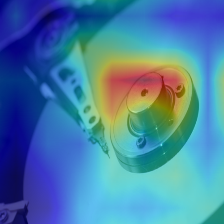

green snake, grass snake


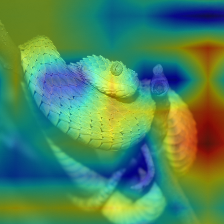

cauliflower


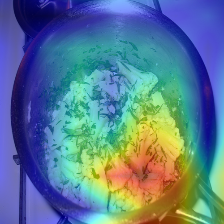

stole


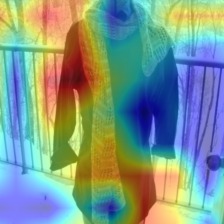

bikini, two-piece


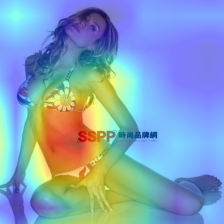

custard apple


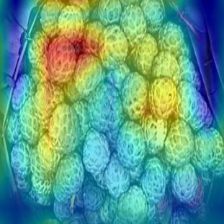

radiator


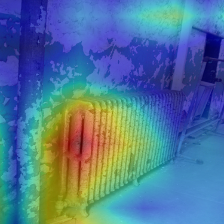

snowmobile


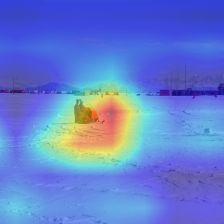

pelican


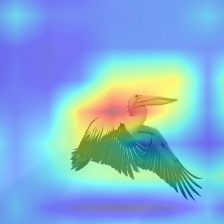

radiator


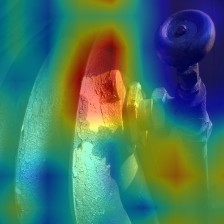

radiator


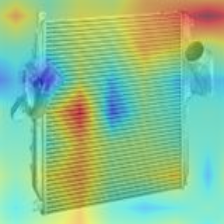

mobile home, manufactured home


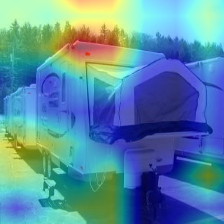

shoe shop, shoe-shop, shoe store


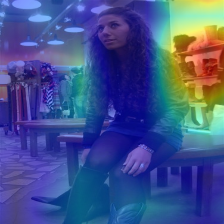

tench, Tinca tinca


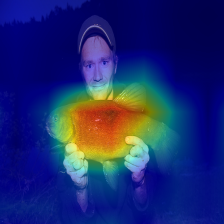

shoe shop, shoe-shop, shoe store


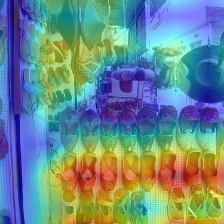

screwdriver


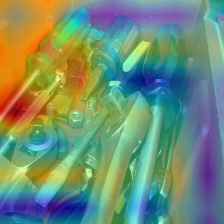

church, church building


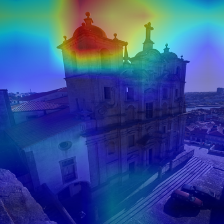

airliner


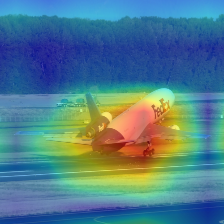

rain barrel


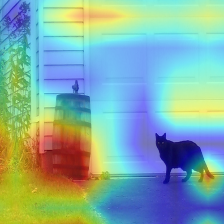

house finch, linnet, Carpodacus mexicanus


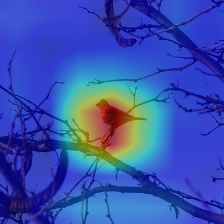

jeep, landrover


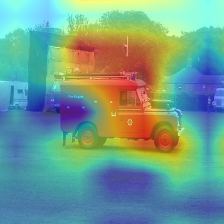

Indian elephant, Elephas maximus


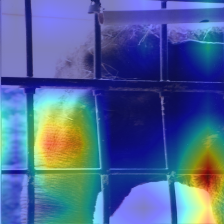

radiator


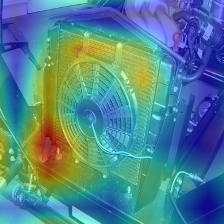

Indian elephant, Elephas maximus


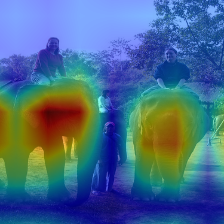

Indian elephant, Elephas maximus


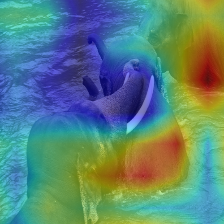

papillon


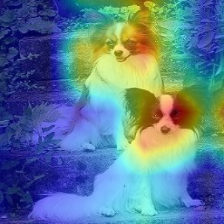

paddle, boat paddle


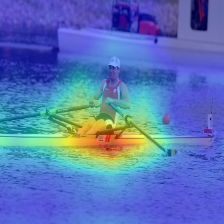

cauliflower


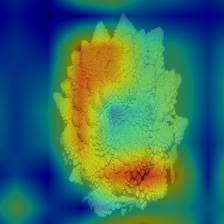

stole


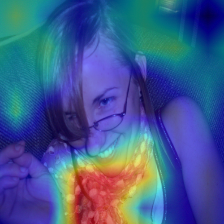

house finch, linnet, Carpodacus mexicanus


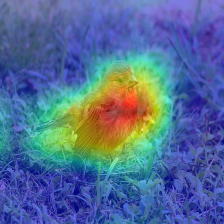

clumber, clumber spaniel


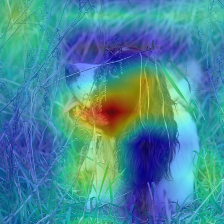

paddle, boat paddle


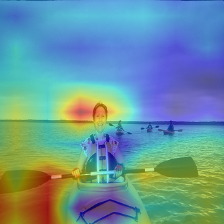

sea snake


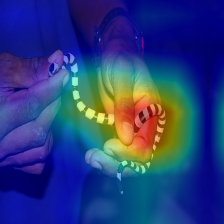

sewing machine


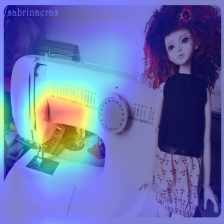

worm fence, snake fence, snake-rail fence, Virginia fence


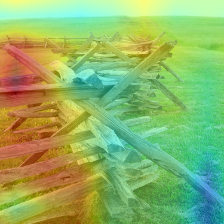

papillon


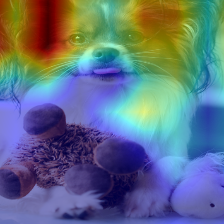

sunglasses, dark glasses, shades


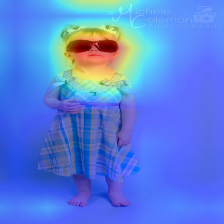

custard apple


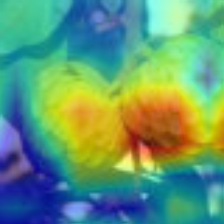

trench coat


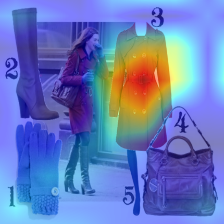

screwdriver


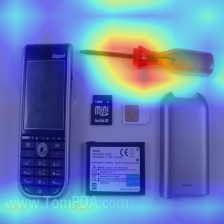

Border terrier


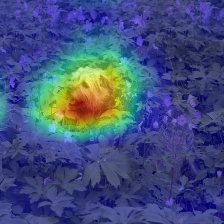

rugby ball


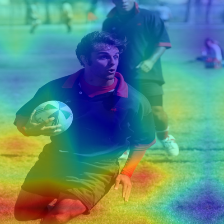

mobile home, manufactured home


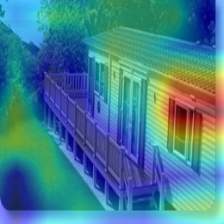

radiator


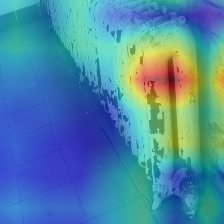

container ship, containership, container vessel


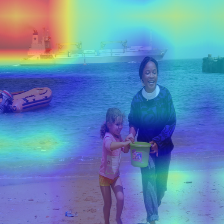

sunglasses, dark glasses, shades


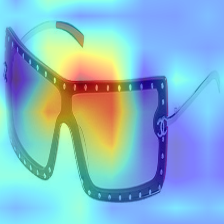

schipperke


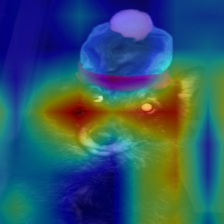

stole


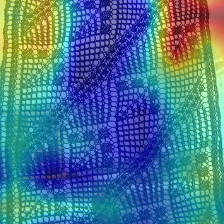

sewing machine


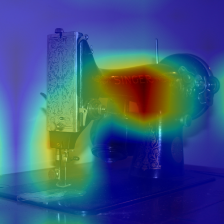

Border terrier


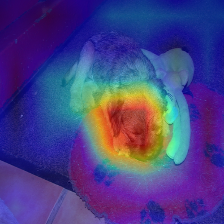

In [ ]:
for img, class_name in zip(saliency_overlayed, class_names):

  print(class_name)
  display(img)

In [ ]:
original_output_binaries = []

for heat_map in heat_maps:

  #original_output_binary = np.mean(np.asarray(heat_map), axis=2).astype('uint8')

  #original_output_binaries.append(original_output_binary)

  original_output_binaries.append(heat_map)


In [ ]:
import pickle

files = open("/content/drive/My Drive/Interpretability Research/Salieny_maps/original_output_binaries.pkl", "wb")
pickle.dump(original_output_binaries , files)
files.close()